**Data Loading and Preparation**

This first part of the code loads the necessary libraries, reads the data from CSV files, and combines them for consistent preprocessing.



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


train_df = pd.read_csv('/content/train.csv', sep=';')
test_df = pd.read_csv('/content/test.csv', sep=';')


combined_df = pd.concat([train_df, test_df], ignore_index=True)


X = combined_df.drop('y', axis=1)
y = combined_df['y'].map({'yes': 1, 'no': 0})

**Measuring Past Campaign Effectiveness**

This segment calculates and prints the baseline conversion rate from the provided data.

In [5]:
past_conversion_rate = y.mean() * 100
print(f"Past Campaign Overall Conversion Rate: {past_conversion_rate:.2f}%")
print("="*60)

Past Campaign Overall Conversion Rate: 11.68%


**Setting Up the Propensity Model Pipeline**

This part defines the data preprocessing steps and the machine learning model within a single, streamlined pipeline.

In [6]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

**Training and Evaluating the Model**

This segment splits the data, trains the model, makes predictions, and generates performance reports and a confusion matrix plot.

Training the Propensity Model...
Model training complete.
Model Performance on Test Data:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      8785
           1       0.78      0.43      0.56      1162

    accuracy                           0.92      9947
   macro avg       0.86      0.71      0.76      9947
weighted avg       0.91      0.92      0.91      9947



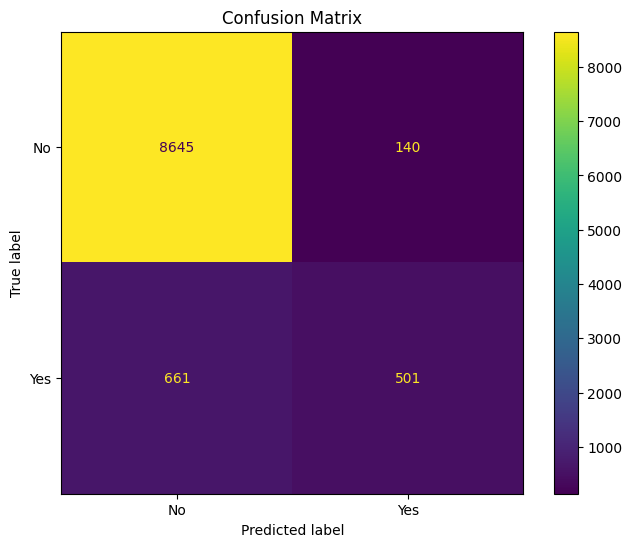

In [7]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the model.
print("Training the Propensity Model...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")
print("="*60)

# Make predictions and get probability scores for the test set.
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_proba > 0.5).astype(int)

print("Model Performance on Test Data:")
print(classification_report(y_test, y_pred_class))
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

**Measuring Gains and Uplift**

This final, large segment calculates and plots the cumulative gains and lift, providing key business insights. It also prints the top 10 most important features from the model.

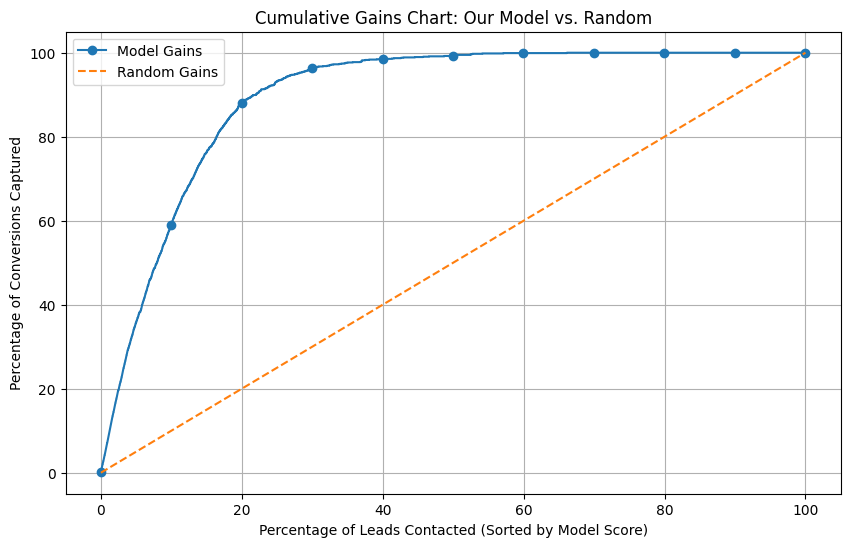

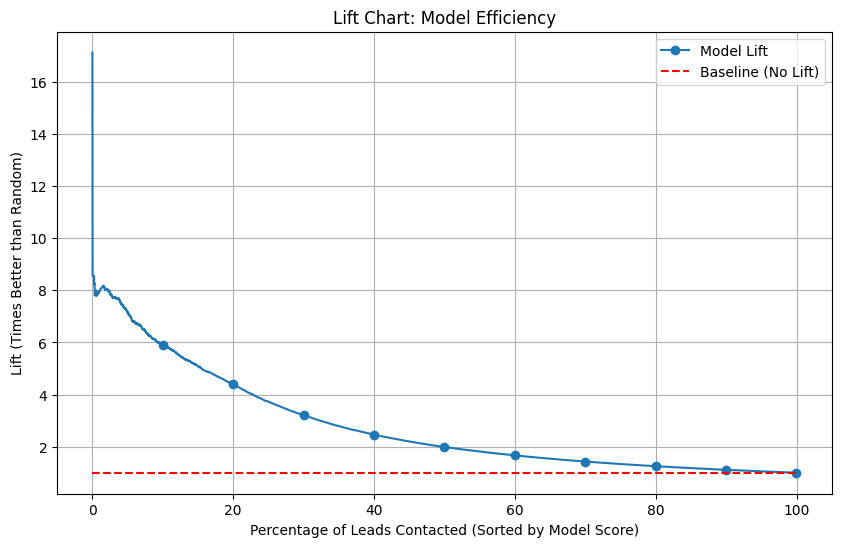

Targeting Insights from Gains Chart:
By contacting the **top 10%** of leads, we capture 58.95% of all conversions.
By contacting the **top 20%** of leads, we capture 88.12% of all conversions.
Top 10 Most Important Factors for Conversion:
            feature  importance
0          duration    0.344871
1           balance    0.076027
2               age    0.070419
3               day    0.066706
4          campaign    0.034826
5  poutcome_success    0.031758
6             pdays    0.030059
7   contact_unknown    0.021227
8  contact_cellular    0.018851
9          previous    0.018479


In [8]:
results_df = pd.DataFrame({
    'predicted_prob': y_pred_proba,
    'actual_conversion': y_test.values
}).sort_values('predicted_prob', ascending=False).reset_index(drop=True)

# Calculate cumulative gains.
results_df['cumulative_conversions'] = results_df['actual_conversion'].cumsum()
total_conversions = results_df['actual_conversion'].sum()
results_df['gains'] = results_df['cumulative_conversions'] / total_conversions * 100
results_df['random_gains'] = np.linspace(0, 100, len(results_df))
results_df['lift'] = results_df['gains'] / results_df['random_gains']
results_df['percentile'] = (results_df.index + 1) / len(results_df) * 100

# Plot the Gains Chart.
plt.figure(figsize=(10, 6))
plt.plot(results_df['percentile'], results_df['gains'], label='Model Gains', marker='o', markevery=int(len(results_df)/10))
plt.plot(results_df['percentile'], results_df['random_gains'], label='Random Gains', linestyle='--')
plt.title('Cumulative Gains Chart: Our Model vs. Random')
plt.xlabel('Percentage of Leads Contacted (Sorted by Model Score)')
plt.ylabel('Percentage of Conversions Captured')
plt.grid(True)
plt.legend()
plt.savefig('gains_chart.png')
plt.show()

# Plot the Lift Chart.
plt.figure(figsize=(10, 6))
plt.plot(results_df['percentile'], results_df['lift'], label='Model Lift', marker='o', markevery=int(len(results_df)/10))
plt.plot([0, 100], [1, 1], 'r--', label='Baseline (No Lift)')
plt.title('Lift Chart: Model Efficiency')
plt.xlabel('Percentage of Leads Contacted (Sorted by Model Score)')
plt.ylabel('Lift (Times Better than Random)')
plt.grid(True)
plt.legend()
plt.savefig('lift_chart.png')
plt.show()

# Show Gains at key thresholds.
print("Targeting Insights from Gains Chart:")
print(f"By contacting the **top 10%** of leads, we capture {results_df['gains'].iloc[int(len(results_df)*0.1)-1]:.2f}% of all conversions.")
print(f"By contacting the **top 20%** of leads, we capture {results_df['gains'].iloc[int(len(results_df)*0.2)-1]:.2f}% of all conversions.")
print("="*60)


feature_importances = model_pipeline.named_steps['classifier'].feature_importances_

ohe_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
all_feature_names = numerical_features + ohe_feature_names
importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 10 Most Important Factors for Conversion:")
print(importance_df.head(10))